Consider the evolution of a simple Hamiltonian into a problem-specific Hamiltonian where the optimal solution is 'encoded' in the ground state of the problem Hamiltonian $\displaystyle \hat{\mathcal{H}}_{\text{P}}$

$$\hat{\mathcal{H}}\left(s\right) = \left(1 - s\right)\gamma\hat{\mathcal{H}}_0 + s\underbrace{\left(\alpha\hat{\mathcal{H}}_{\text{A}} + \hat{\mathcal{H}}_{\text{B}}\right)}_{\hat{\mathcal{H}}_{\text{P}}},\qquad\hat{\mathcal{H}}_{\text{B}} = -\sum_{i = 1}^np_ix_i$$

for some $\displaystyle s = \frac{t}{T}$ where $T$ is the total computation time with

$$\begin{dcases}
    \quad\hat{\mathcal{H}}_0 = -\sum_i\sigma_x^i,\qquad&\left(\text{Transverse}\right)\\
    \quad\hat{\mathcal{H}}_0 = -\sum_{i < j}\sigma_x^i\sigma_x^j,\qquad&\left(\text{Mixed}\right)
\end{dcases}$$

and

$$\hat{\mathcal{H}}_{\text{A}} = \left[\sum_{j = 0}^{M - 1}2^jy_j + \left(c + 1 - 2^M\right)y_M - \sum_{i = 1}^nw_ix_i\right]^2,\qquad S\left(n\right) = O\left(n + \left\lfloor\log_2c\right\rfloor + 1\right)$$

where $\displaystyle \alpha > \max\left(p_j\right)$ and $\displaystyle M = \left\lfloor\log_2c\right\rfloor$ s.t. $2^{\ell + 1} \leq c < 2^{M + 1}$


In [1]:
from engine import Coffey, MakeGraphCoffey
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

,1,2,3,4,5
Profit,8,3,5,6,9
Weight,1,2,1,3,2


Note that by default, H_0 will use take the form of a transverse Hamiltonian!

gamma parameter has been set to: 1.0

alpha parameter has been set to default as: 10.0

Annealing complete in 12.145s!
Probabilities calculated in 0.002s!
Probabilities calculated in 2.188s!
Spectrum simulated in 0.022s!


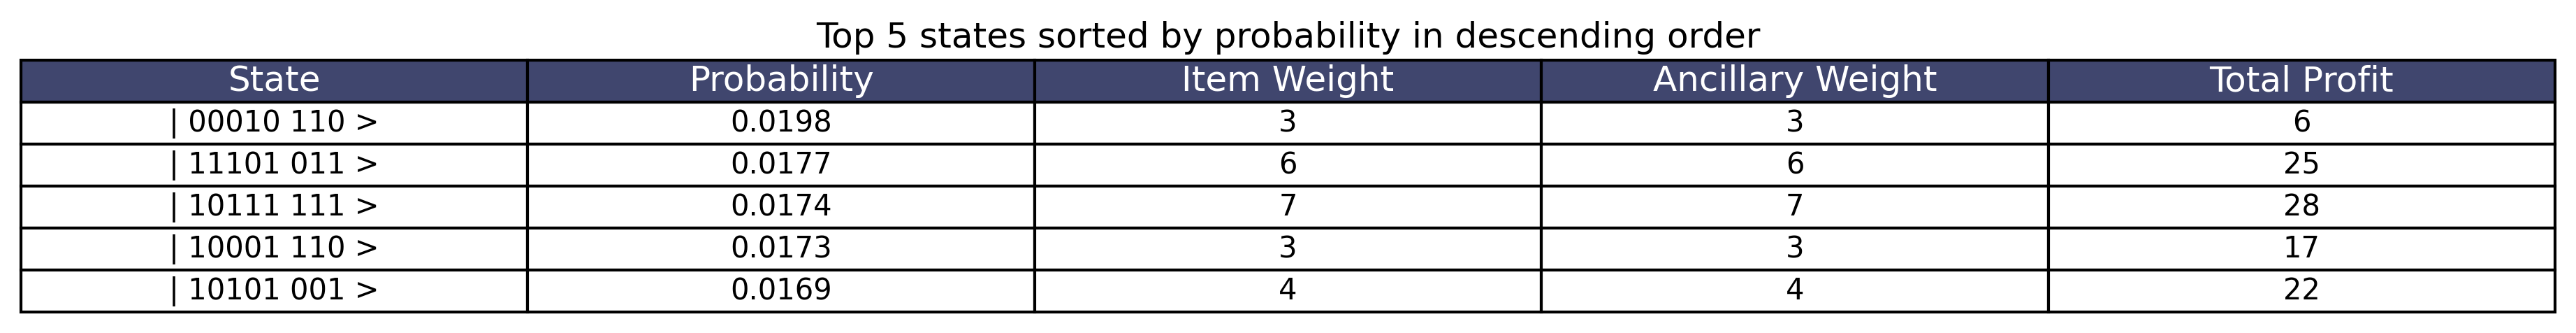

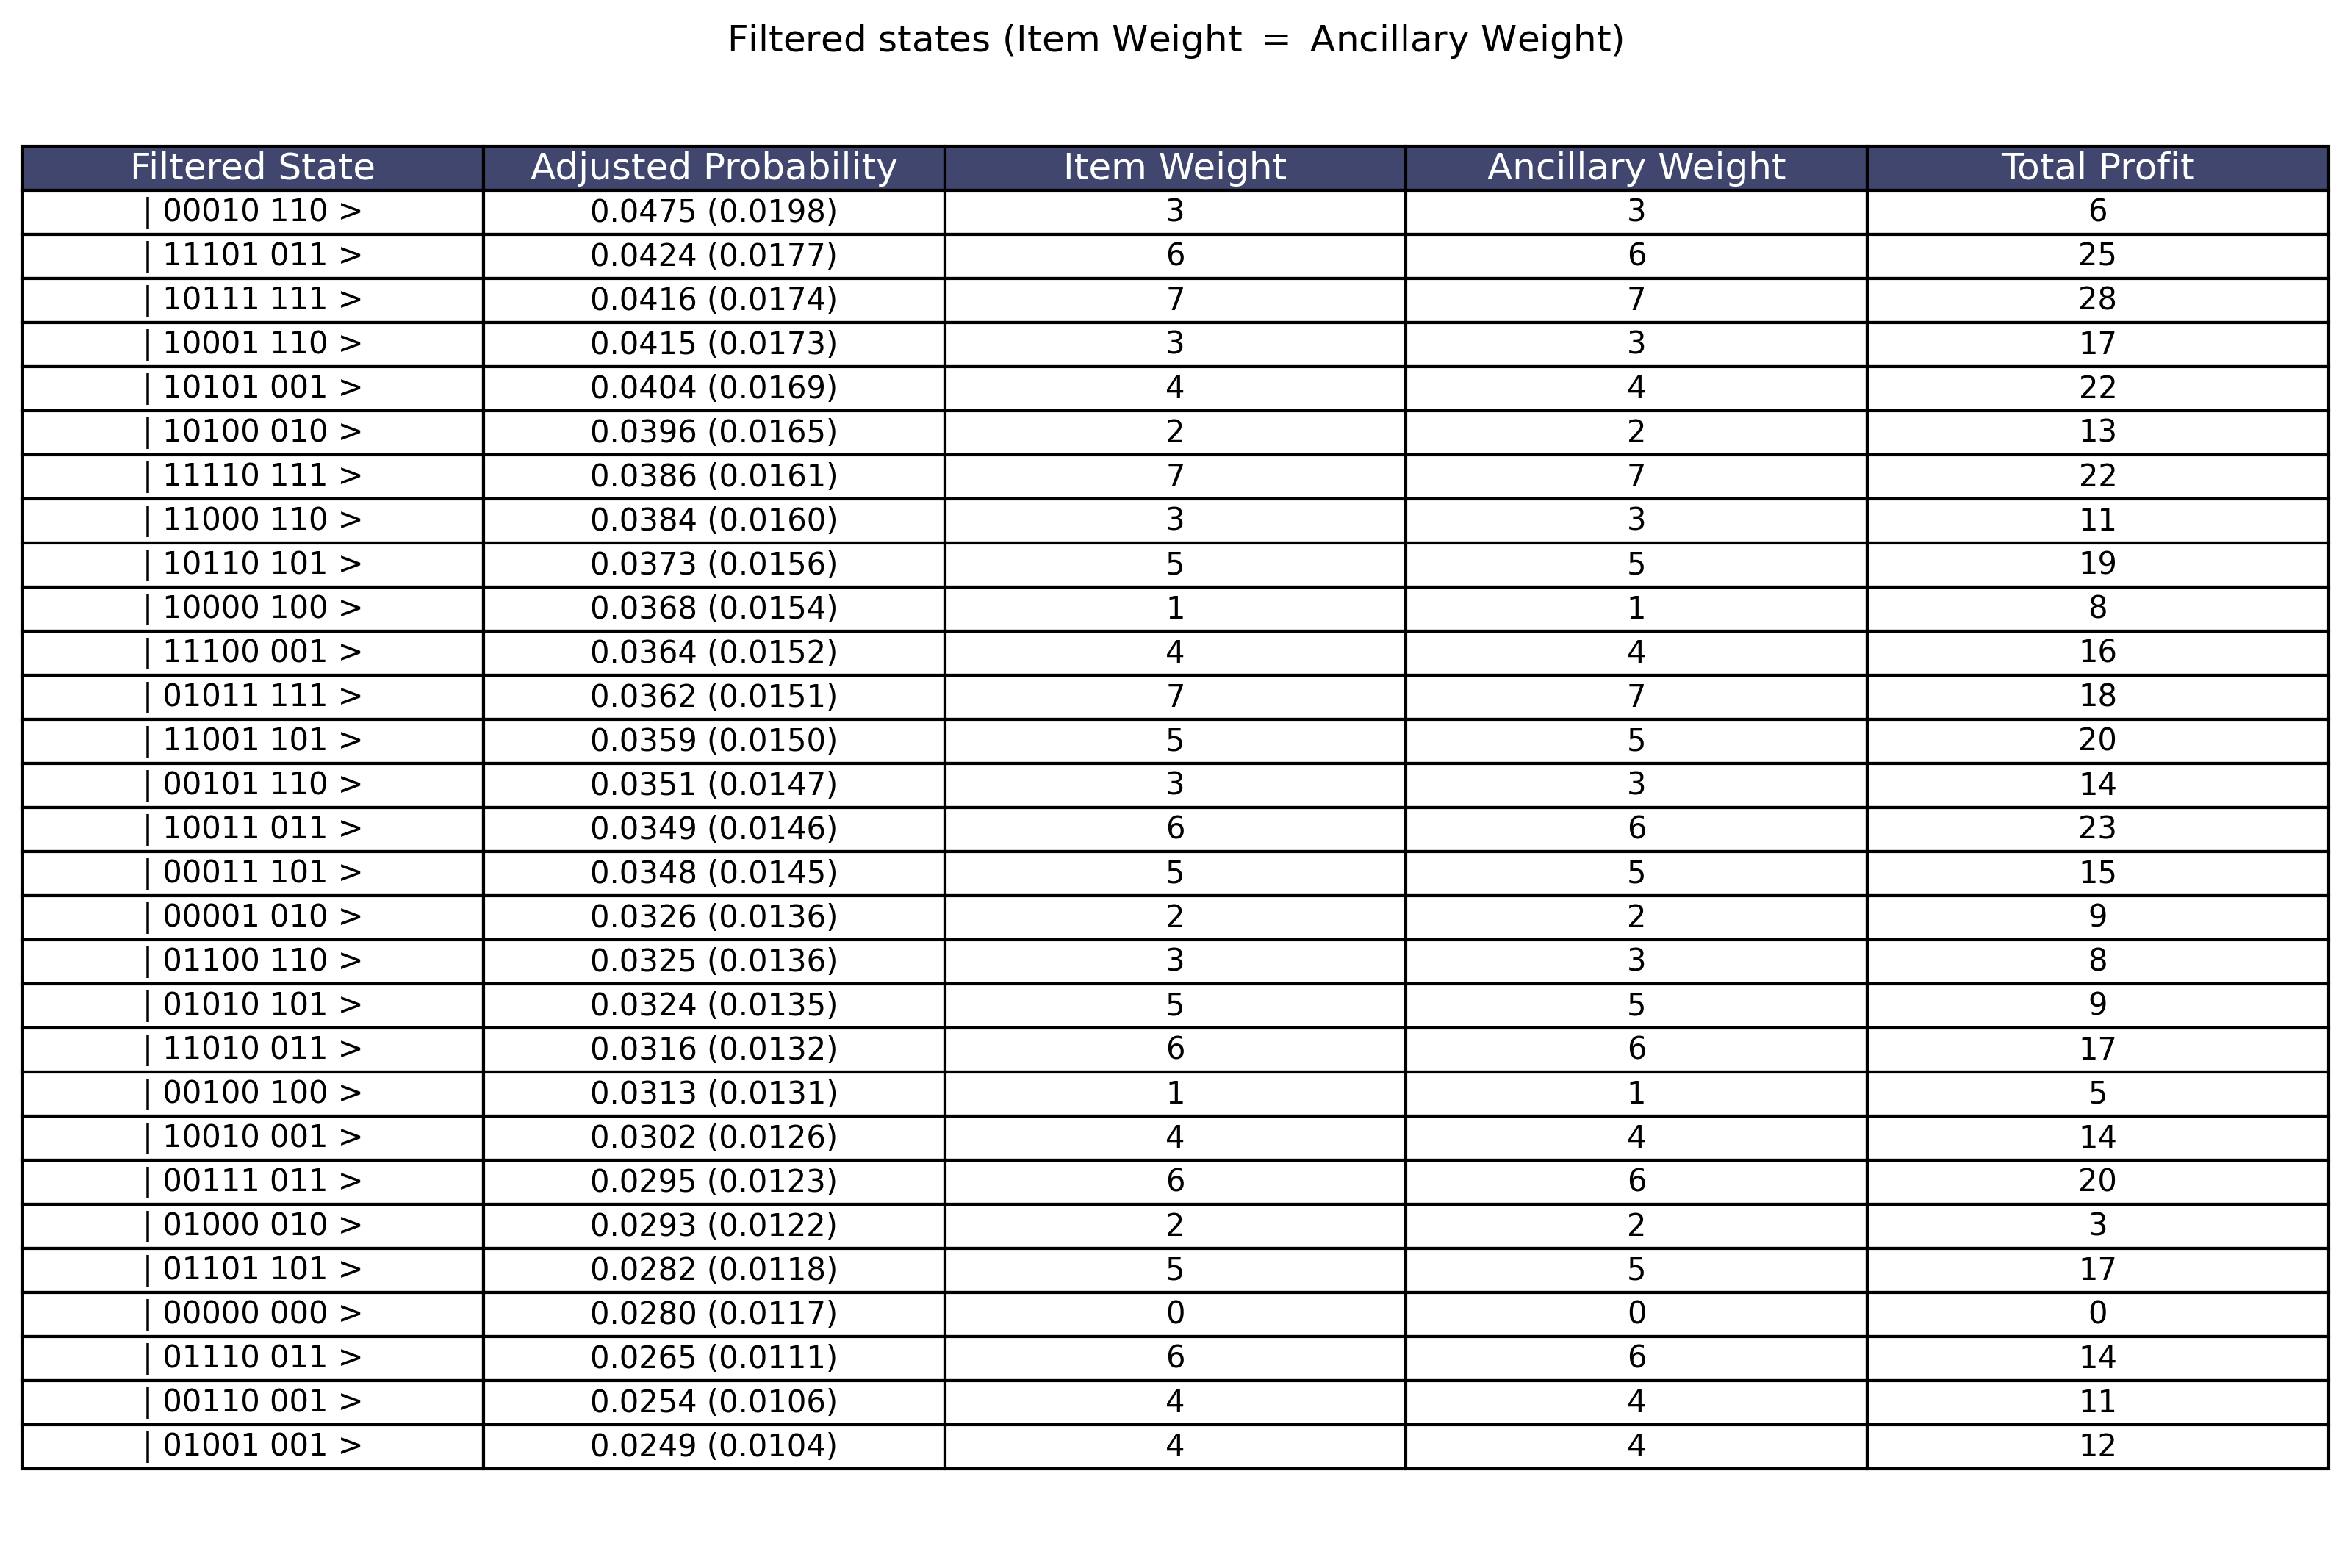

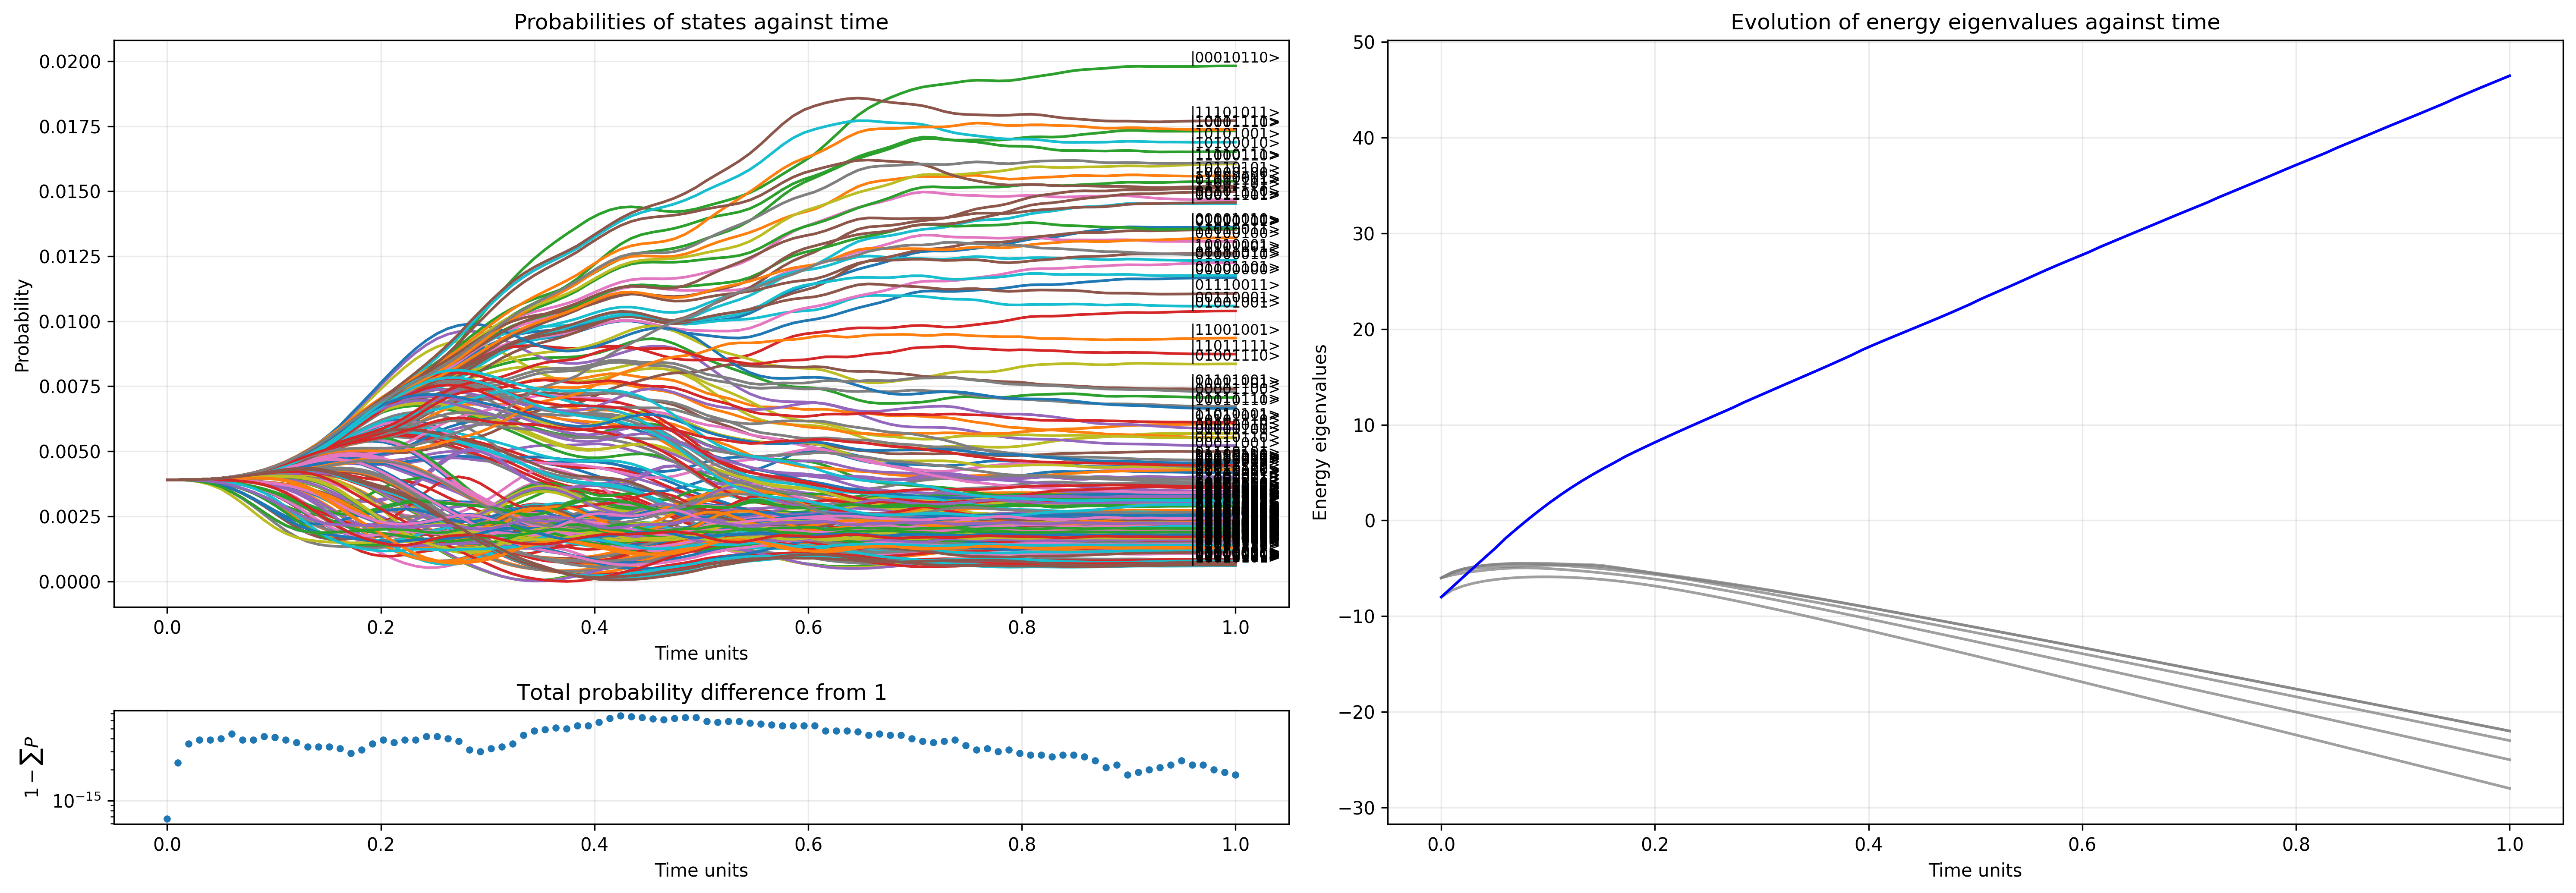

In [2]:
#   Parameters to set
# profits = np.array([3, 2])
# weights = np.array([1, 2])
# capacity = 2

profits = np.array([8, 3, 5, 6, 9])
weights = np.array([1, 2, 1, 3, 2])
capacity = 7

# profits = np.array([6, 5, 8, 9, 6, 7, 3])
# weights = np.array([2, 3, 6, 7, 5, 8, 4])
# capacity = 9

df = pd.DataFrame({"Profit": profits, "Weight": weights}).T
df.columns = range(1, len(df.columns) + 1)

display(df)

num_steps = 1000
num_sub_steps = 100

sim = Coffey(profits, weights, capacity)

# sim.set_H_0_state("mixed")
# sim.set_gamma(10.0)
# sim.set_alpha(12)

res = sim.anneal(num_steps)
probs = sim.compute_probs(res, num_sub_steps)
simulated_spectrum = sim.simulate_spectrum(num_sub_steps)
computed_spectrum = sim.compute_spectrum(res, num_sub_steps)

dis = MakeGraphCoffey()
dis.set_probs(probs)
dis.set_simulated_spectrum(simulated_spectrum)
dis.set_computed_spectrum(computed_spectrum)

dis.display_probs(sim)
dis.display_filtered_probs(sim)
dis.display_graph(sim, 5)

In [ ]:
valid_solutions = sim.get_H_P_ground_states()
print(
    f"Optimal states: {["| " + psi + " >" for psi in valid_solutions]}\n(Note that there may of may not be degeneracies!)"
)

sim.set_output_status(False)

In [ ]:
def plot_1(
    lower_alpha: float,
    upper_alpha: float,
    lower_gamma: float,
    upper_gamma: float,
    steps: int,
) -> None:
    alphas = np.linspace(
        np.max(sim.get_profits()) + lower_alpha,
        np.max(sim.get_profits()) + upper_alpha,
        steps,
    )
    gammas = np.linspace(lower_gamma, upper_gamma, steps)

    prob_mat1 = np.zeros((alphas.shape[0], gammas.shape[0]))
    prob_mat2 = np.zeros((alphas.shape[0], gammas.shape[0]))

    for i, alpha in enumerate(alphas):
        sim.set_alpha(alpha)
        for j, gamma in enumerate(gammas):
            sim.set_gamma(gamma)
            sim.set_H_0_state("transverse")
            final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
            prob_mat1[i, j] = sum(
                prob
                for idx, prob in enumerate(final_probs)
                if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
            )
            sim.set_H_0_state("mixed")
            final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
            prob_mat2[i, j] = sum(
                prob
                for idx, prob in enumerate(final_probs)
                if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
            )

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=300)

    cax1 = ax1.imshow(
        prob_mat1,
        extent=[gammas.min(), gammas.max(), alphas.min(), alphas.max()],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,
    )
    fig.colorbar(cax1, ax=ax1, label="Solution probability")
    ax1.set(
        xlabel=r"$\gamma$",
        ylabel=r"$\alpha$",
        title=r"Solution probability Heatmap  (Transverse $\hat{\mathcal{H}}_0$)",
    )
    ax1.grid(False)

    cax2 = ax2.imshow(
        prob_mat2,
        extent=[gammas.min(), gammas.max(), alphas.min(), alphas.max()],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=1.0,
    )
    fig.colorbar(cax2, ax=ax2, label="Solution probability")
    ax2.set(
        xlabel=r"$\gamma$",
        ylabel=r"$\alpha$",
        title=r"Solution probability Heatmap (Mixed $\hat{\mathcal{H}}_0$)",
    )
    ax2.grid(False)

    plt.tight_layout()
    plt.show()


plot_1(1, 100, 1, 100, 100)

In [ ]:
def plot_2(lower: float, upper: float, steps: int) -> None:
    probs = []
    probs2 = []
    sim.set_alpha(0.0)
    gammas = np.linspace(lower, upper, steps)
    for gamma in gammas:
        sim.set_H_0_state("transverse")
        sim.set_gamma(gamma)
        final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
        probs.append(
            sum(
                prob
                for idx, prob in enumerate(final_probs)
                if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
            )
        )

        sim.set_H_0_state("mixed")
        final_probs = sim.compute_probs(sim.anneal(num_steps), num_sub_steps)[-1]
        probs2.append(
            sum(
                prob
                for idx, prob in enumerate(final_probs)
                if format(idx, f"0{sim.get_total_qubits()}b") in valid_solutions
            )
        )

    _, ax = plt.subplots(figsize=(10, 7), dpi=300)
    ax.plot(gammas, probs, label="transverse")
    ax.plot(gammas, probs2, label="mixed")
    ax.set(
        xlabel=r"$\gamma$",
        ylabel=r"Total probability to obtain correct solution",
        title=r"Probability of obtaining correct solution against choice of $\gamma$",
    )
    ax.grid(True, alpha=0.25)
    ax.legend()

    plt.show()


plot_2(1, 200, 100)